In [1]:
%matplotlib inline

In [2]:
from collections import defaultdict
from kid_readout.measurement.io import nc, npy
from kid_readout.measurement import temperature

In [3]:
plot_directory = '/home/flanigan/temp/'

In [4]:
data_directory = '/data/detectors/'

# In temperature and almost chronological order
roots = ['/data/detectors/2016-08-16_134703_sweep_stream_on_off.nc',  # 120 mK
         '/data/detectors/2016-08-08_165530_sweep_stream_on_off.nc',  # 150 mK
         '/data/detectors/2016-08-17_115635_sweep_stream_on_off.nc',  # 200 mK
         '/data/detectors/2016-08-18_125356_sweep_stream_on_off/',  # 250 mK
         '/data/detectors/2016-08-22_153758_sweep_stream_on_off/',  # 280 mK
         '/data/detectors/2016-08-23_112113_sweep_stream_on_off/',  # 300 mK
        ]

In [5]:
npd = npy.NumpyDirectory(roots[-1])

In [6]:
npd.node_names()

['SingleSweepStream0',
 'SingleSweep1',
 'SingleStream2',
 'ADCSnap3',
 'SingleSweepStream4',
 'SingleSweep5',
 'SingleStream6',
 'ADCSnap7',
 'SingleSweepStream8',
 'SingleSweep9',
 'SingleStream10',
 'ADCSnap11',
 'SingleSweepStream12',
 'SingleSweep13',
 'SingleStream14',
 'ADCSnap15',
 'SingleSweepStream16',
 'SingleSweep17',
 'SingleStream18',
 'ADCSnap19',
 'SingleSweepStream20',
 'SingleSweep21',
 'SingleStream22',
 'ADCSnap23',
 'SingleSweepStream24',
 'SingleSweep25',
 'SingleStream26',
 'ADCSnap27',
 'SingleSweepStream28',
 'SingleSweep29',
 'SingleStream30',
 'ADCSnap31',
 'SingleSweepStream32',
 'SingleSweep33',
 'SingleStream34',
 'ADCSnap35',
 'SingleSweepStream36',
 'SingleSweep37',
 'SingleStream38',
 'ADCSnap39',
 'SingleSweepStream40',
 'SingleSweep41',
 'SingleStream42',
 'ADCSnap43',
 'SingleSweepStream44',
 'SingleSweep45',
 'SingleStream46',
 'ADCSnap47',
 'SingleSweepStream48',
 'SingleSweep49',
 'SingleStream50',
 'ADCSnap51',
 'SingleSweepStream52',
 'SingleSwe

In [31]:
num_channels = 8
num_attenuations = 4
attenuation_index = 3
nodes_per_attenuation = 4
node_index = 0

first = attenuation_index * nodes_per_attenuation + node_index
skip = num_attenuations * nodes_per_attenuation

fr_GHz = np.concatenate((np.linspace(2.5, 2.75, 4), np.linspace(3.75, 4.0, 4)))

In [8]:
sss_dict = defaultdict(list)
for root in roots:
    print(root)
    if root.endswith('.nc'):
        f = nc.NCFile(root)
    else:
        f = npy.NumpyDirectory(root)
    for channel, name in enumerate(f.node_names()[first::skip]):
        sss_dict[channel].append(f.read(name))
    f.close()



/data/detectors/2016-08-08_165530_sweep_stream_on_off.nc
/data/detectors/2016-08-16_134703_sweep_stream_on_off.nc
/data/detectors/2016-08-17_115635_sweep_stream_on_off.nc
/data/detectors/2016-08-18_125356_sweep_stream_on_off/
/data/detectors/2016-08-22_153758_sweep_stream_on_off/
/data/detectors/2016-08-23_112113_sweep_stream_on_off/


In [9]:
for channel in range(num_channels):
    assert np.all([sss.state.lo_index==channel for sss in sss_dict[channel]])

In [49]:
for channel in range(num_channels):
    sss_dict[channel].insert(0, sss_dict[channel].pop(1))

In [10]:
for channel_list in sss_dict.values():
    for sss in channel_list:
        temperature.add_temperature(sss, cryostat='hpd')

In [32]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'brown']

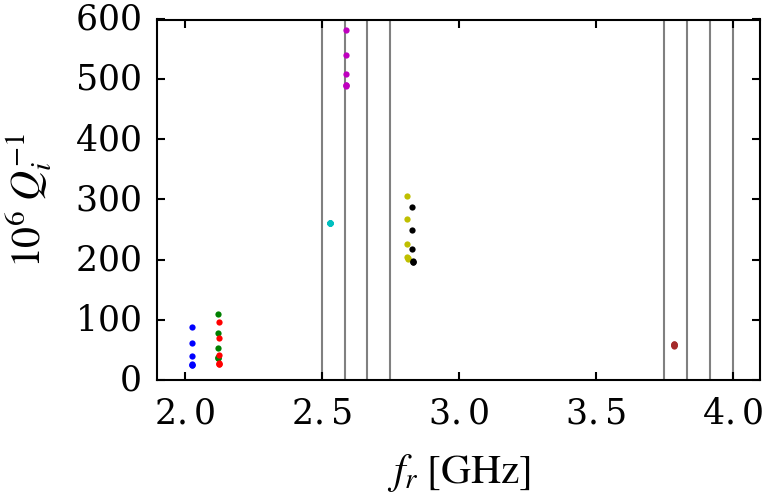

In [62]:
fig, ax = plt.subplots()
ax.set_xlabel('$f_r \; [\mathrm{GHz}]$')
ax.set_ylabel('$10^6 \; Q_i^{-1}$')
for fr in fr_GHz:
    ax.axvline(fr, color='gray')
    
for channel in range(num_channels):
    for sss in sss_dict[channel]:
        ax.plot(1e-9 * sss.resonator.f_0,
                1e6 / sss.resonator.Q_i,
                '.', color=colors[channel])
ax.set_xlim(1.9, 4.1)

fig.savefig(plot_directory + 'iQi_vs_fr.pdf', bbox_inches='tight')

In [90]:
1 - 2.1 / 2.75

0.23636363636363633

In [91]:
1 - 2.8 / 4.0

0.30000000000000004

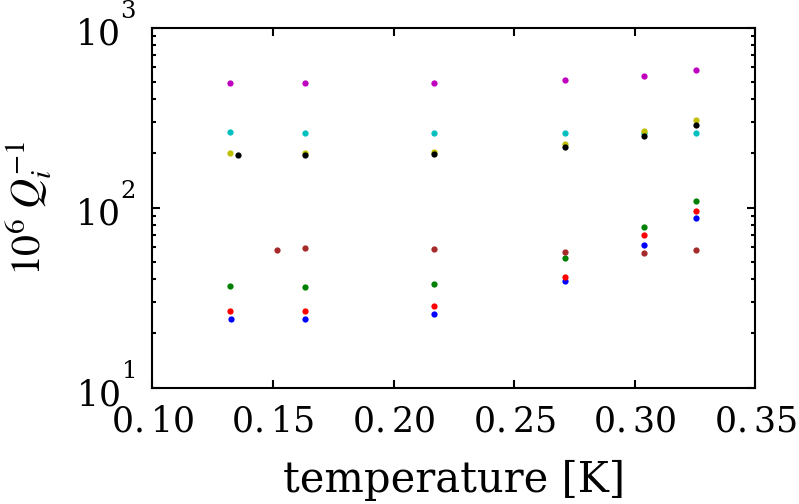

In [63]:
fig, ax = plt.subplots()
ax.set_xlabel('temperature [K]')
ax.set_ylabel('$10^6 \; Q_i^{-1}$')
ax.set_yscale('log')

for channel in range(num_channels):
    for sss in sss_dict[channel]:
        ax.plot(sss.state.temperature.primary_package,
                1e6 / sss.resonator.Q_i, '.', color=colors[channel])

fig.savefig(plot_directory + 'iQi_vs_T.pdf', bbox_inches='tight')

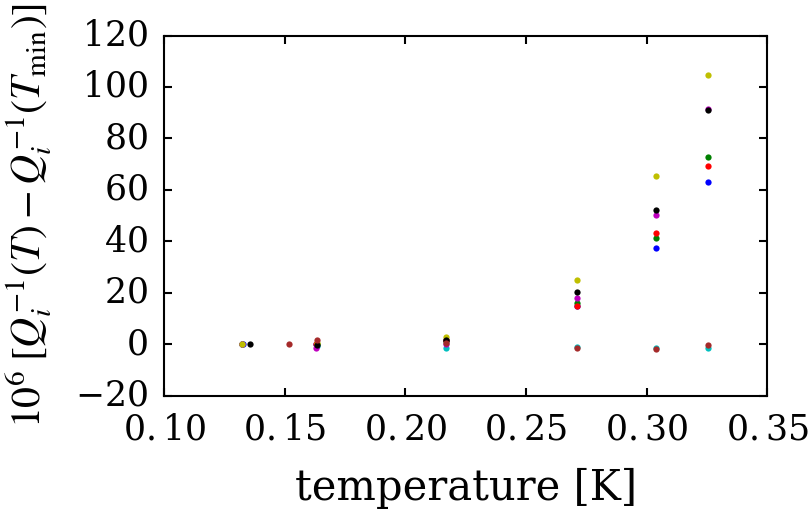

In [64]:
fig, ax = plt.subplots()
ax.set_xlabel('temperature [K]')
ax.set_ylabel('$10^6 \; [Q_i^{-1}(T) - Q_i^{-1}(T_\mathrm{min})]$')

for channel in range(num_channels):
    for sss in sss_dict[channel]:
        ax.plot(sss.state.temperature.primary_package,
                1e6 * (1 / sss.resonator.Q_i - 1 / sss_dict[channel][0].resonator.Q_i), '.', color=colors[channel])
    
fig.savefig(plot_directory + 'diQi_vs_T.pdf', bbox_inches='tight')

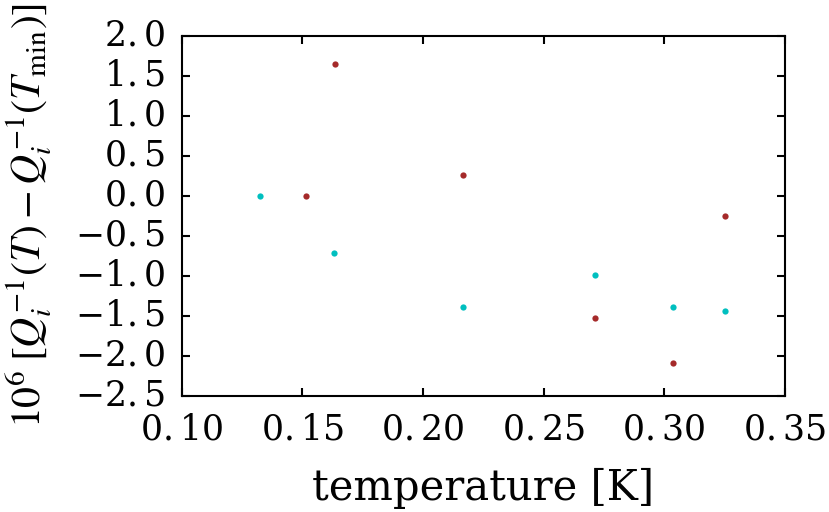

In [88]:
fig, ax = plt.subplots()
ax.set_xlabel('temperature [K]')
ax.set_ylabel('$10^6 \; [Q_i^{-1}(T) - Q_i^{-1}(T_\mathrm{min})]$')

for channel in [3, 7]:
    for sss in sss_dict[channel]:
        ax.plot(sss.state.temperature.primary_package,
                1e6 * (1 / sss.resonator.Q_i - 1 / sss_dict[channel][0].resonator.Q_i), '.', color=colors[channel])
    
#fig.savefig(plot_directory + 'diQi_vs_T.pdf', bbox_inches='tight')

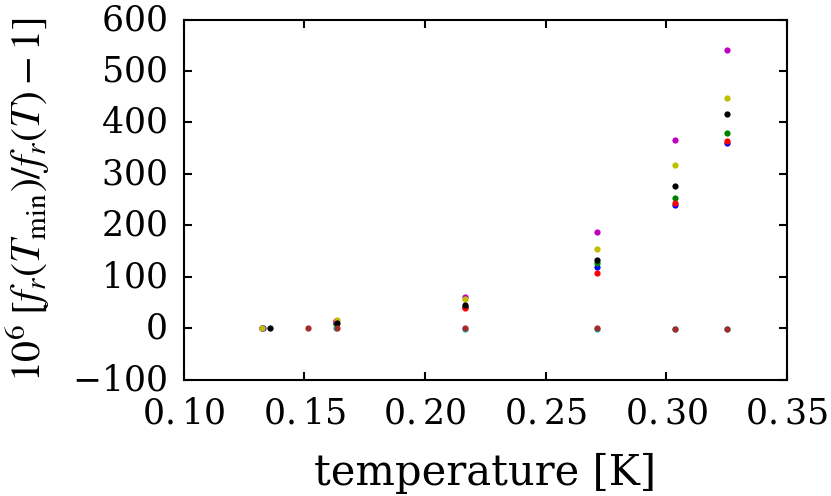

In [65]:
fig, ax = plt.subplots()
ax.set_xlabel('temperature [K]')
ax.set_ylabel('$10^6 \; [f_r(T_\mathrm{min}) / f_r(T) - 1]$')

for channel in range(num_channels):
    for sss in sss_dict[channel]:
        ax.plot(sss.state.temperature.primary_package,
                1e6 * (sss_dict[channel][0].resonator.f_0 / sss.resonator.f_0 - 1), '.', color=colors[channel])

fig.savefig(plot_directory + 'x_vs_T.pdf', bbox_inches='tight')

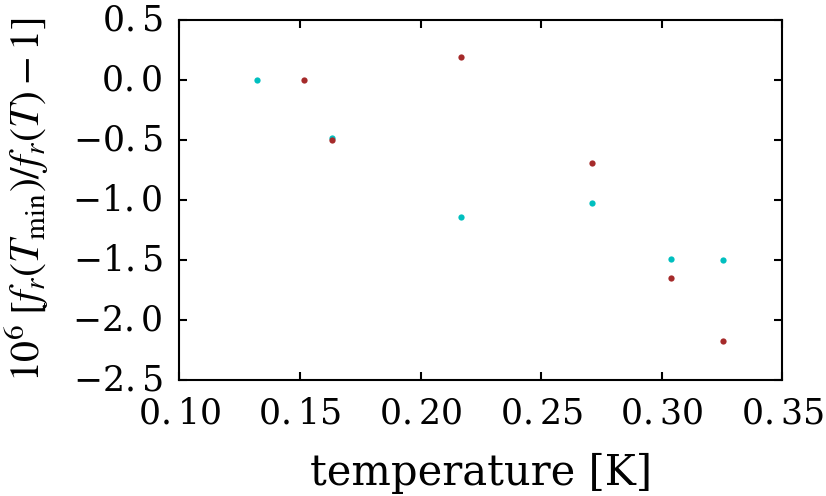

In [87]:
fig, ax = plt.subplots()
ax.set_xlabel('temperature [K]')
ax.set_ylabel('$10^6 \; [f_r(T_\mathrm{min}) / f_r(T) - 1]$')

for channel in [3, 7]:
    for sss in sss_dict[channel]:
        ax.plot(sss.state.temperature.primary_package,
                1e6 * (sss_dict[channel][0].resonator.f_0 / sss.resonator.f_0 - 1), '.', color=colors[channel])

#fig.savefig(plot_directory + 'x_vs_T.pdf', bbox_inches='tight')

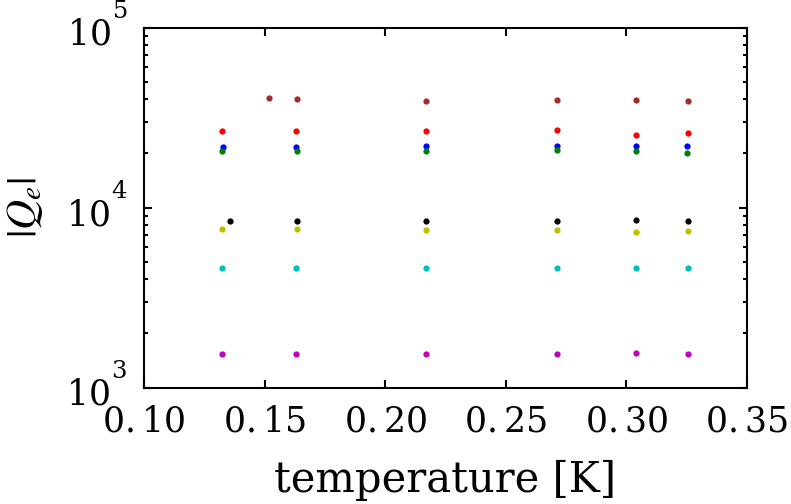

In [66]:
fig, ax = plt.subplots()
ax.set_xlabel('temperature [K]')
ax.set_ylabel('$|Q_e|$')
ax.set_yscale('log')

for channel in range(num_channels):
    for sss in sss_dict[channel]:
        ax.plot(sss.state.temperature.primary_package,
                np.abs(sss.resonator.Q_e), '.', color=colors[channel])
    
fig.savefig(plot_directory + 'Qe_vs_T.pdf', bbox_inches='tight')

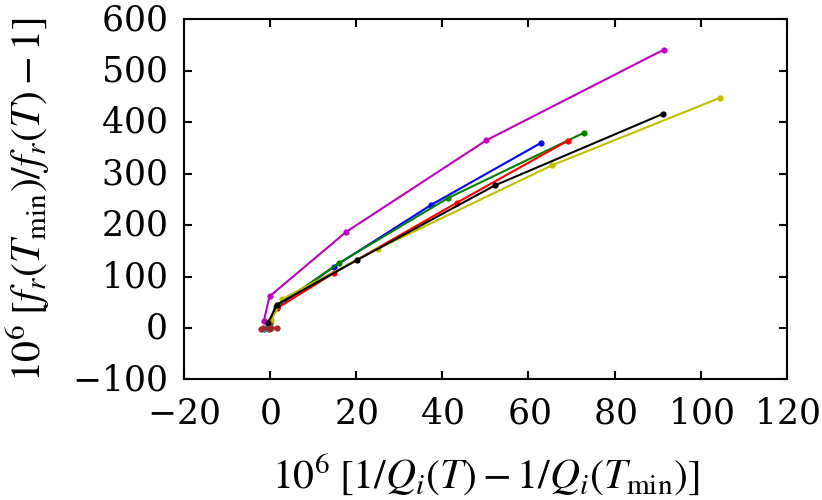

In [71]:
fig, ax = plt.subplots()
ax.set_xlabel('$10^6 \; [1 / Q_i(T) - 1 / Q_i(T_\mathrm{min})]$')
ax.set_ylabel('$10^6 \; [f_r(T_\mathrm{min}) / f_r(T) - 1]$')
for channel in range(num_channels):
    x = np.array([sss_dict[channel][0].resonator.f_0 / sss.resonator.f_0 - 1
                  for sss in sss_dict[channel]])
    iQi = np.array([1 / sss.resonator.Q_i - 1 / sss_dict[channel][0].resonator.Q_i
                    for sss in sss_dict[channel]])
    ax.plot(1e6 * iQi,
            1e6 * x,
            '.-', color=colors[channel])

fig.savefig(plot_directory + 'x_vs_iQi.pdf', bbox_inches='tight')

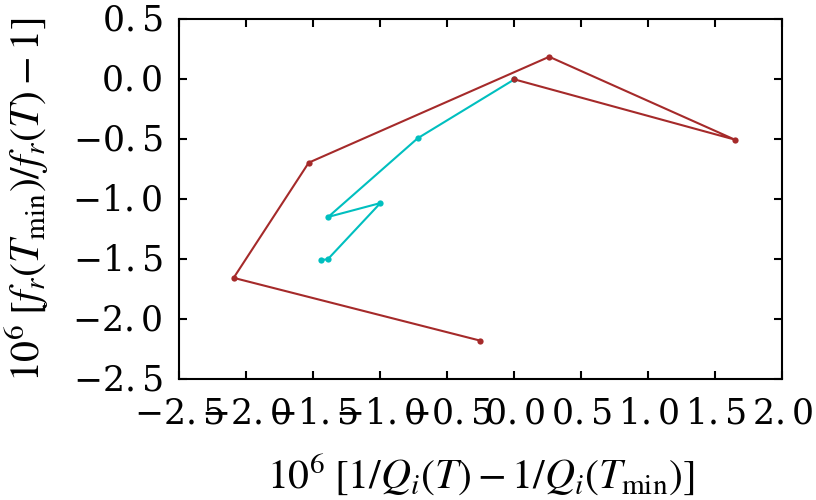

In [85]:
fig, ax = plt.subplots()
ax.set_xlabel('$10^6 \; [1 / Q_i(T) - 1 / Q_i(T_\mathrm{min})]$')
ax.set_ylabel('$10^6 \; [f_r(T_\mathrm{min}) / f_r(T) - 1]$')
for channel in [3, 7]:
    x = np.array([sss_dict[channel][0].resonator.f_0 / sss.resonator.f_0 - 1
                  for sss in sss_dict[channel]])
    iQi = np.array([1 / sss.resonator.Q_i - 1 / sss_dict[channel][0].resonator.Q_i
                    for sss in sss_dict[channel]])
    ax.plot(1e6 * iQi,
            1e6 * x,
            '.-', color=colors[channel])

#fig.savefig(plot_directory + 'x_vs_iQi_niobium.pdf', bbox_inches='tight')

In [68]:
from physics.mkid import noroozian

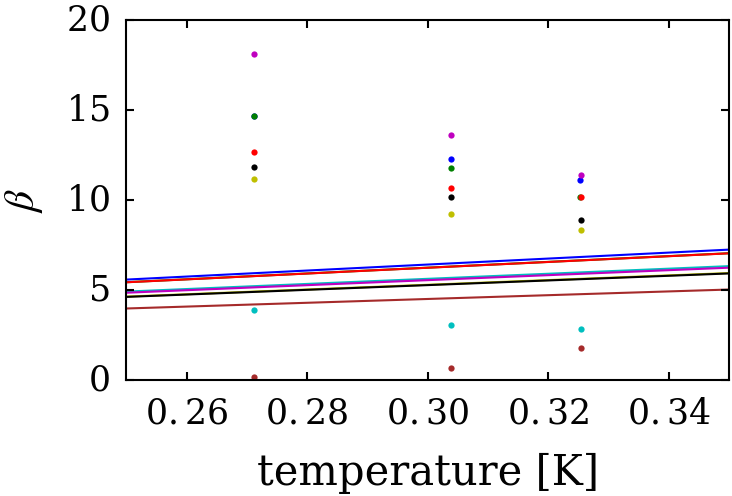

In [84]:
Tc = 1.39
TT = np.linspace(0.150, 0.350, 1000)

fig, ax = plt.subplots()
ax.set_xlabel('temperature [K]')
ax.set_ylabel(r'$\beta$')

for channel in range(num_channels):
    sss_list = sss_dict[channel][1:]
    x = np.array([sss_list[0].resonator.f_0 / sss.resonator.f_0 - 1 for sss in sss_list])
    iQi = np.array([1 / sss.resonator.Q_i - 1 / sss_list[0].resonator.Q_i for sss in sss_list])
    beta = 2 * x / iQi
    T = np.array([sss.state.temperature.primary_package for sss in sss_list])
    ax.plot(T, beta,
            '.', color=colors[channel])
    ax.plot(TT, noroozian.beta(f=sss_list[0].resonator.f_0, T=TT, Delta_0=noroozian.BCS_Delta_0(Tc)),
            '-', color=colors[channel])

ax.set_xlim(0.250, 0.350)
ax.set_ylim(0, 20);